# Predicción de Supervivencia de Pacientes con Cirrosis mediante Machine Learning

## Punto 4: Entrenamiento y Evaluación de Modelos

En esta sección desarrollaremos la configuración experimental y evaluación de múltiples modelos de aprendizaje automático para predecir la supervivencia de pacientes con cirrosis. 

Basándonos en el análisis preliminar, hemos decidido convertir el problema de clasificación multiclase original (C, CL, D) a un problema de clasificación binaria (Sobrevive/No sobrevive) para mejorar la interpretabilidad y el rendimiento de los modelos.

### 4.1 Configuración Experimental


In [1]:
# Celda 1: Importaciones (Corregida)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif # <--- IMPORTACIÓN AÑADIDA

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Pipelines y manejo de desbalanceo
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Carga de datos
from ucimlrepo import fetch_ucirepo 
cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878) 
X = cirrhosis_patient_survival_prediction.data.features 
y = cirrhosis_patient_survival_prediction.data.targets

In [2]:
# Exploración inicial de los datos
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Forma de las características (X): {X.shape}")
print(f"Forma de la variable objetivo (y): {y.shape}")
print(f"\nTipos de datos en X:")
print(X.dtypes)
print(f"\nTipos de datos en y:")
print(y.dtypes)


=== INFORMACIÓN GENERAL DEL DATASET ===
Forma de las características (X): (418, 17)
Forma de la variable objetivo (y): (418, 1)

Tipos de datos en X:
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol       object
Albumin          float64
Copper            object
Alk_Phos         float64
SGOT             float64
Tryglicerides     object
Platelets         object
Prothrombin      float64
Stage            float64
dtype: object

Tipos de datos en y:
Status    object
dtype: object


In [3]:
# Visualizar las primeras filas de los datos
print("=== PRIMERAS 5 FILAS DE CARACTERÍSTICAS (X) ===")
print(X.head())
print(f"\n=== PRIMERAS 5 FILAS DE VARIABLE OBJETIVO (y) ===")
print(y.head())
print(f"\n=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO ORIGINAL ===")
print(y.value_counts())
print(f"\nPorcentajes:")
print(y.value_counts(normalize=True) * 100)

# Convertir la variable objetivo a clasificación binaria: C (Censurado) vs No Censurado (CL+D)
print(f"\n=== CONVERSIÓN A CLASIFICACIÓN BINARIA ===")
print("Interpretación de valores originales:")
print("- C: Censurado (el paciente sobrevivió hasta el final del estudio)")
print("- CL: Censurado por trasplante hepático")
print("- D: Muerte (paciente falleció durante el estudio)")

# Crear una nueva variable objetivo binaria
# Consideramos que C es "Sobrevive" y CL/D son "No sobrevive"
y_binary = y.copy()
y_binary['Status'] = y_binary['Status'].map({'C': 'Sobrevive', 'CL': 'No_sobrevive', 'D': 'No_sobrevive'})

print(f"\n=== DISTRIBUCIÓN DE LA VARIABLE OBJETIVO BINARIA ===")
print(y_binary.value_counts())
print(f"\nPorcentajes:")
print(y_binary.value_counts(normalize=True) * 100)


=== PRIMERAS 5 FILAS DE CARACTERÍSTICAS (X) ===
              Drug    Age Sex Ascites Hepatomegaly Spiders Edema  Bilirubin  \
0  D-penicillamine  21464   F       Y            Y       Y     Y       14.5   
1  D-penicillamine  20617   F       N            Y       Y     N        1.1   
2  D-penicillamine  25594   M       N            N       N     S        1.4   
3  D-penicillamine  19994   F       N            Y       Y     S        1.8   
4          Placebo  13918   F       N            Y       Y     N        3.4   

  Cholesterol  Albumin Copper  Alk_Phos    SGOT Tryglicerides Platelets  \
0         261     2.60    156    1718.0  137.95           172       190   
1         302     4.14     54    7394.8  113.52            88       221   
2         176     3.48    210     516.0   96.10            55       151   
3         244     2.54     64    6121.8   60.63            92       183   
4         279     3.53    143     671.0  113.15            72       136   

   Prothrombin  Stage  
0 

=== ANÁLISIS DE VALORES FALTANTES ===
         Variable  Valores_Faltantes  Porcentaje
8     Cholesterol                106   25.358852
10         Copper                106   25.358852
13  Tryglicerides                106   25.358852
12           SGOT                106   25.358852
11       Alk_Phos                106   25.358852
0            Drug                105   25.119617
5         Spiders                105   25.119617
4    Hepatomegaly                105   25.119617
3         Ascites                105   25.119617
14      Platelets                  7    1.674641
16          Stage                  6    1.435407
15    Prothrombin                  2    0.478469


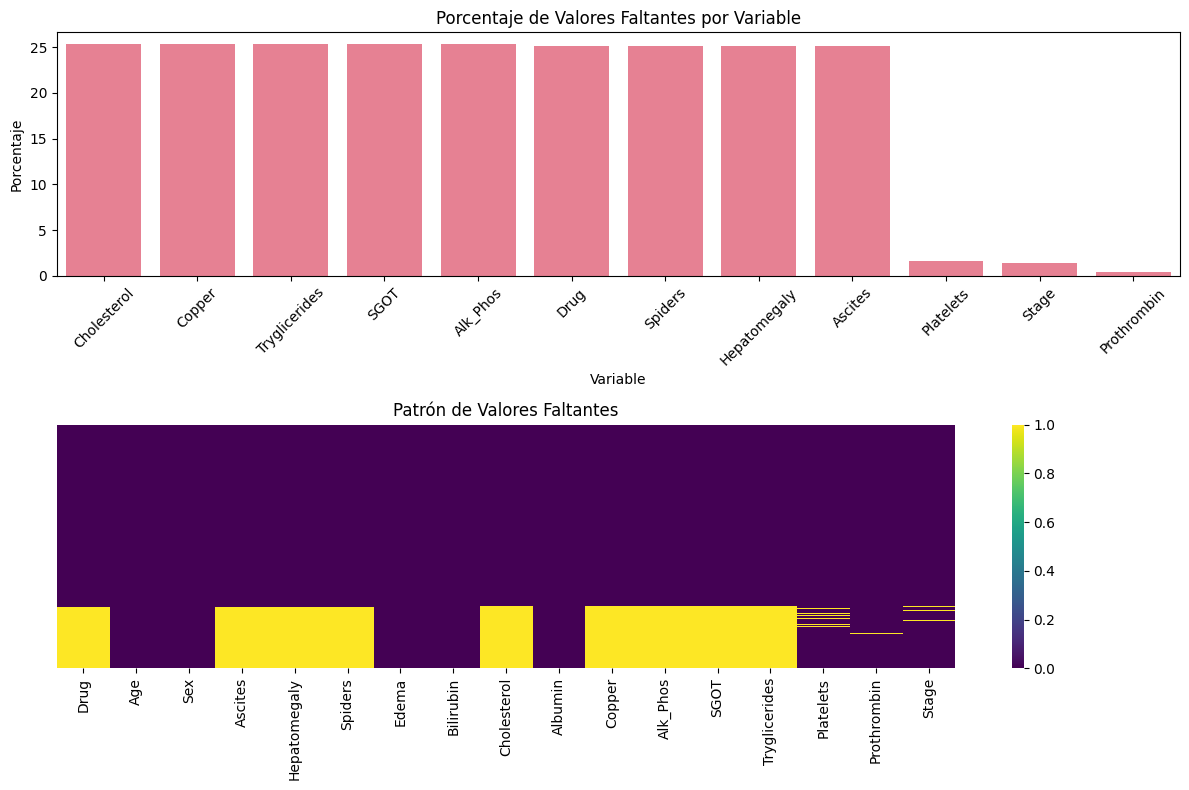

In [4]:
# Análisis de valores faltantes
print("=== ANÁLISIS DE VALORES FALTANTES ===")
missing_values = X.isnull().sum()
missing_percentage = (missing_values / len(X)) * 100

missing_df = pd.DataFrame({
    'Variable': missing_values.index,
    'Valores_Faltantes': missing_values.values,
    'Porcentaje': missing_percentage.values
}).sort_values('Porcentaje', ascending=False)

print(missing_df[missing_df['Valores_Faltantes'] > 0])

# Visualización de valores faltantes
plt.figure(figsize=(12, 8))
missing_data = missing_df[missing_df['Valores_Faltantes'] > 0]
if not missing_data.empty:
    plt.subplot(2, 1, 1)
    sns.barplot(data=missing_data, x='Variable', y='Porcentaje')
    plt.title('Porcentaje de Valores Faltantes por Variable')
    plt.xticks(rotation=45)
    
    # Heatmap de valores faltantes
    plt.subplot(2, 1, 2)
    sns.heatmap(X.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Patrón de Valores Faltantes')
    
plt.tight_layout()
plt.show()


In [5]:
# Identificar variables categóricas y numéricas
print("=== IDENTIFICACIÓN DE TIPOS DE VARIABLES ===")

# Variables categóricas (object type)
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()
print(f"Variables categóricas ({len(categorical_vars)}): {categorical_vars}")

# Variables numéricas
numerical_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Variables numéricas ({len(numerical_vars)}): {numerical_vars}")

# Análisis de variables categóricas
print(f"\n=== ANÁLISIS DE VARIABLES CATEGÓRICAS ===")
for var in categorical_vars:
    print(f"\n{var}:")
    print(X[var].value_counts())
    print(f"Valores únicos: {X[var].nunique()}")

# Estadísticas descriptivas de variables numéricas
print(f"\n=== ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES NUMÉRICAS ===")
print(X[numerical_vars].describe())


=== IDENTIFICACIÓN DE TIPOS DE VARIABLES ===
Variables categóricas (10): ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']
Variables numéricas (7): ['Age', 'Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT', 'Prothrombin', 'Stage']

=== ANÁLISIS DE VARIABLES CATEGÓRICAS ===

Drug:
Drug
D-penicillamine    158
Placebo            154
NaNN                 1
Name: count, dtype: int64
Valores únicos: 3

Sex:
Sex
F    374
M     44
Name: count, dtype: int64
Valores únicos: 2

Ascites:
Ascites
N       288
Y        24
NaNN      1
Name: count, dtype: int64
Valores únicos: 3

Hepatomegaly:
Hepatomegaly
Y       160
N       152
NaNN      1
Name: count, dtype: int64
Valores únicos: 3

Spiders:
Spiders
N       222
Y        90
NaNN      1
Name: count, dtype: int64
Valores únicos: 3

Edema:
Edema
N    354
S     44
Y     20
Name: count, dtype: int64
Valores únicos: 3

Cholesterol:
Cholesterol
NaNN    28
260      4
316      4
448      4
257      

#### Preprocesamiento de Datos

En esta sección realizaremos la limpieza y preparación de los datos, incluyendo:
- Manejo de valores faltantes
- Codificación de variables categóricas  
- Normalización de variables numéricas
- División de datos en entrenamiento/validación/test


In [6]:
# Crear una copia para el preprocesamiento
X_processed = X.copy()
y_processed = y_binary.copy()  # Usamos la variable objetivo binaria

print("=== PREPROCESAMIENTO DE DATOS ===")

# 1. Manejo de valores faltantes
print("\n1. Manejo de valores faltantes:")

# Para variables numéricas: imputación con la mediana
numerical_imputer = SimpleImputer(strategy='median')
X_processed[numerical_vars] = numerical_imputer.fit_transform(X_processed[numerical_vars])

# Para variables categóricas: imputación con la moda
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_processed[categorical_vars] = categorical_imputer.fit_transform(X_processed[categorical_vars])

print("✓ Valores faltantes imputados")
print(f"Valores faltantes restantes: {X_processed.isnull().sum().sum()}")

# 2. Codificación de variables categóricas
print("\n2. Codificación de variables categóricas:")

# Variables categóricas binarias se codifican con LabelEncoder
binary_vars = []
for var in categorical_vars:
    unique_vals = X_processed[var].nunique()
    if unique_vals == 2:
        binary_vars.append(var)
        le = LabelEncoder()
        X_processed[var] = le.fit_transform(X_processed[var])
        print(f"✓ {var}: LabelEncoder aplicado (valores únicos: {unique_vals})")

# Variables categóricas con más de 2 valores se codifican con OneHot
multi_category_vars = [var for var in categorical_vars if var not in binary_vars]
if multi_category_vars:
    # Crear variables dummy
    X_encoded = pd.get_dummies(X_processed, columns=multi_category_vars, prefix=multi_category_vars)
    print(f"✓ OneHot encoding aplicado a: {multi_category_vars}")
else:
    X_encoded = X_processed.copy()

print(f"Forma de datos después de codificación: {X_encoded.shape}")

# 3. Codificación de variable objetivo binaria
print("\n3. Codificación de variable objetivo binaria:")
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y_processed.values.ravel())
print(f"Clases binarias: {label_encoder_y.classes_}")
print(f"Distribución después de codificación: {np.bincount(y_encoded)}")
print(f"Correspondencia: 0 = {label_encoder_y.classes_[0]}, 1 = {label_encoder_y.classes_[1]}")

# Guardar las columnas finales
final_columns = X_encoded.columns.tolist()
print(f"\nVariables finales ({len(final_columns)}): {final_columns}")


=== PREPROCESAMIENTO DE DATOS ===

1. Manejo de valores faltantes:
✓ Valores faltantes imputados
Valores faltantes restantes: 0

2. Codificación de variables categóricas:
✓ Sex: LabelEncoder aplicado (valores únicos: 2)
✓ OneHot encoding aplicado a: ['Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']
Forma de datos después de codificación: (418, 775)

3. Codificación de variable objetivo binaria:
Clases binarias: ['No_sobrevive' 'Sobrevive']
Distribución después de codificación: [186 232]
Correspondencia: 0 = No_sobrevive, 1 = Sobrevive

Variables finales (775): ['Age', 'Sex', 'Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT', 'Prothrombin', 'Stage', 'Drug_D-penicillamine', 'Drug_NaNN', 'Drug_Placebo', 'Ascites_N', 'Ascites_NaNN', 'Ascites_Y', 'Hepatomegaly_N', 'Hepatomegaly_NaNN', 'Hepatomegaly_Y', 'Spiders_N', 'Spiders_NaNN', 'Spiders_Y', 'Edema_N', 'Edema_S', 'Edema_Y', 'Cholesterol_1000', 'Cholesterol_1015', 'Cholesterol_1092', 'C

=== DIVISIÓN DE DATOS ===
Entrenamiento: 292 muestras (69.9%)
Validación: 63 muestras (15.1%)
Test: 63 muestras (15.1%)

Distribución de clases en entrenamiento: [130 162]
Distribución de clases en validación: [28 35]
Distribución de clases en test: [28 35]

=== NORMALIZACIÓN DE DATOS ===
✓ Datos normalizados usando StandardScaler
Media de entrenamiento escalado: -0.000000
Desviación estándar de entrenamiento escalado: 0.813006

=== MANEJO DEL DESBALANCEO DE CLASES CON SMOTE ===
✓ SMOTE aplicado a los datos de entrenamiento
Forma de los datos de entrenamiento antes de SMOTE: (292, 775)
Forma de los datos de entrenamiento después de SMOTE: (324, 775)
Distribución de clases antes de SMOTE: [130 162]
Distribución de clases después de SMOTE: [162 162]


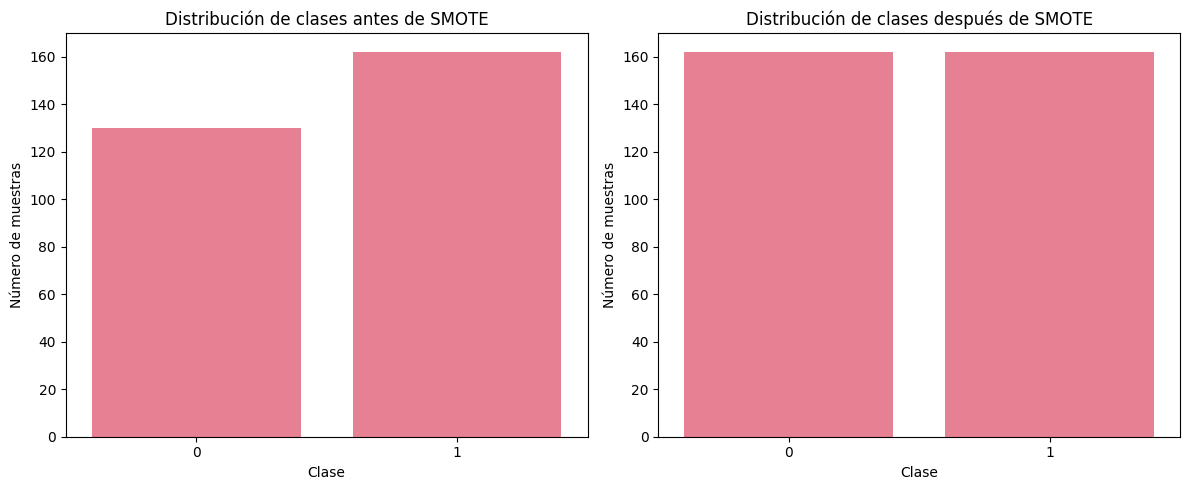


=== PREPROCESAMIENTO COMPLETADO ===
Datos listos para entrenamiento con 775 características


In [7]:
# 4. División de datos
print("=== DIVISIÓN DE DATOS ===")

# División inicial: 70% entrenamiento, 30% temporal
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y_encoded, 
    test_size=0.30, 
    random_state=42, 
    stratify=y_encoded
)

# División del 30% temporal: 15% validación, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42, 
    stratify=y_temp
)

print(f"Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"Validación: {X_val.shape[0]} muestras ({X_val.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X_encoded)*100:.1f}%)")

# Verificar distribución de clases
print(f"\nDistribución de clases en entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases en validación: {np.bincount(y_val)}")
print(f"Distribución de clases en test: {np.bincount(y_test)}")

# 5. Normalización de datos
print("\n=== NORMALIZACIÓN DE DATOS ===")

# Ajustar el scaler solo con datos de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de vuelta a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=final_columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=final_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=final_columns)

print("✓ Datos normalizados usando StandardScaler")
print(f"Media de entrenamiento escalado: {X_train_scaled.mean().mean():.6f}")
print(f"Desviación estándar de entrenamiento escalado: {X_train_scaled.std().mean():.6f}")

# 6. Manejo del desbalanceo de clases con SMOTE
print("\n=== MANEJO DEL DESBALANCEO DE CLASES CON SMOTE ===")

# Aplicar SMOTE solo a los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("✓ SMOTE aplicado a los datos de entrenamiento")
print(f"Forma de los datos de entrenamiento antes de SMOTE: {X_train_scaled.shape}")
print(f"Forma de los datos de entrenamiento después de SMOTE: {X_train_smote.shape}")
print(f"Distribución de clases antes de SMOTE: {np.bincount(y_train)}")
print(f"Distribución de clases después de SMOTE: {np.bincount(y_train_smote)}")

# Visualizar la distribución de clases antes y después de SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Distribución de clases antes de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote)
plt.title('Distribución de clases después de SMOTE')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')

plt.tight_layout()
plt.savefig('graficas/distribucion_clases_smote.png', bbox_inches='tight', dpi=300)
plt.show()

print("\n=== PREPROCESAMIENTO COMPLETADO ===")
print(f"Datos listos para entrenamiento con {X_train_scaled.shape[1]} características")


#### Definición de Modelos y Grilla de Hiperparámetros

Según la guía, debemos evaluar **al menos 5 modelos** de diferentes tipos:

1. **Modelo Paramétrico**: Regresión Logística
2. **Modelo No Paramétrico**: K-Nearest Neighbors (KNN)  
3. **Ensamble de Árboles**: Random Forest y XGBoost
4. **Red Neuronal**: Multi-Layer Perceptron (MLP)
5. **Máquina de Vectores de Soporte**: SVM

A continuación definimos las grillas de hiperparámetros para cada modelo:


In [8]:
# Definición de modelos y grillas de hiperparámetros (VERSIÓN OPTIMIZADA)
print("=== DEFINICIÓN DE MODELOS Y HIPERPARÁMETROS (VERSIÓN OPTIMIZADA) ===")

# Configuración de validación cruzada
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Diccionario de modelos con sus grillas de hiperparámetros
models_config = {
    'Logistic_Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['liblinear']
        },
        'description': 'Modelo paramétrico basado en regresión logística binaria'
    },
    
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },
        'description': 'Modelo no paramétrico basado en k-vecinos más cercanos'
    },
    
    'Random_Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 15, 20],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', 'log2']
        },
        'description': 'Ensamble de árboles de decisión con Random Forest'
    },
    
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [4, 5, 6],
            'learning_rate': [0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'description': 'Ensamble de árboles con Gradient Boosting (XGBoost)'
    },
    
    'MLP': {
        'model': MLPClassifier(random_state=42, max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['relu'],
            'alpha': [0.001, 0.01],
            'learning_rate': ['adaptive']
        },
        'description': 'Red neuronal artificial multicapa (MLP)'
    },
    
    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [1, 10, 100],
            'kernel': ['rbf'], # Eliminado 'poly', el principal culpable
            'gamma': ['scale', 'auto']
        },
        'description': 'Máquina de vectores de soporte con kernel RBF'
    }
}

# Mostrar tabla de hiperparámetros
print("\nTabla de Hiperparámetros por Modelo:")
print("="*80)
for name, config in models_config.items():
    print(f"\n{name}:")
    print(f"  Descripción: {config['description']}")
    print(f"  Hiperparámetros:")
    for param, values in config['params'].items():
        print(f"    - {param}: {values}")
    total_combinations = np.prod([len(v) for v in config['params'].values()])
    print(f"  Total combinaciones: {total_combinations}")

print(f"\nTotal de modelos a evaluar: {len(models_config)}")
print("Método de validación: Stratified 5-Fold Cross Validation")

=== DEFINICIÓN DE MODELOS Y HIPERPARÁMETROS (VERSIÓN OPTIMIZADA) ===

Tabla de Hiperparámetros por Modelo:

Logistic_Regression:
  Descripción: Modelo paramétrico basado en regresión logística binaria
  Hiperparámetros:
    - C: [0.1, 1, 10]
    - penalty: ['l2']
    - solver: ['liblinear']
  Total combinaciones: 3

KNN:
  Descripción: Modelo no paramétrico basado en k-vecinos más cercanos
  Hiperparámetros:
    - n_neighbors: [5, 7, 9, 11]
    - weights: ['uniform', 'distance']
    - metric: ['euclidean', 'manhattan']
  Total combinaciones: 16

Random_Forest:
  Descripción: Ensamble de árboles de decisión con Random Forest
  Hiperparámetros:
    - n_estimators: [100, 200]
    - max_depth: [10, 15, 20]
    - min_samples_split: [2, 5]
    - max_features: ['sqrt', 'log2']
  Total combinaciones: 24

XGBoost:
  Descripción: Ensamble de árboles con Gradient Boosting (XGBoost)
  Hiperparámetros:
    - n_estimators: [100, 200]
    - max_depth: [4, 5, 6]
    - learning_rate: [0.1, 0.2]
    - s

In [9]:
# Definición de métricas de evaluación para clasificación binaria
print("=== MÉTRICAS DE EVALUACIÓN PARA CLASIFICACIÓN BINARIA ===")

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report,
                           confusion_matrix, roc_curve, auc, precision_recall_curve, 
                           average_precision_score)

def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name=""):
    """
    Función para evaluar un modelo de clasificación binaria con múltiples métricas
    """
    results = {}
    
    # Métricas básicas
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, zero_division=0)
    results['recall'] = recall_score(y_true, y_pred, zero_division=0)
    results['f1_score'] = f1_score(y_true, y_pred, zero_division=0)
    results['specificity'] = (confusion_matrix(y_true, y_pred)[0, 0] / 
                            (confusion_matrix(y_true, y_pred)[0, 0] + 
                            confusion_matrix(y_true, y_pred)[0, 1]) 
                            if (confusion_matrix(y_true, y_pred)[0, 0] + 
                                confusion_matrix(y_true, y_pred)[0, 1]) > 0 else 0)
    
    # AUC-ROC y AUC-PR (si se tienen probabilidades)
    if y_pred_proba is not None:
        try:
            # Para clasificación binaria, usamos la probabilidad de la clase positiva (1)
            if y_pred_proba.shape[1] == 2:  # Si tenemos probabilidades para ambas clases
                pos_proba = y_pred_proba[:, 1]
            else:  # Si solo tenemos la probabilidad para una clase
                pos_proba = y_pred_proba
                
            results['auc_roc'] = roc_auc_score(y_true, pos_proba)
            results['avg_precision'] = average_precision_score(y_true, pos_proba)
        except:
            results['auc_roc'] = np.nan
            results['avg_precision'] = np.nan
    
    return results

def plot_model_evaluation(y_true, y_pred, y_pred_proba=None, model_name=""):
    """
    Función para visualizar las métricas de evaluación del modelo
    """
    plt.figure(figsize=(15, 5))
    
    # 1. Matriz de confusión
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=label_encoder_y.classes_,
                yticklabels=label_encoder_y.classes_)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    
    # Si tenemos probabilidades, también mostramos curvas ROC y Precision-Recall
    if y_pred_proba is not None and y_pred_proba.shape[1] == 2:
        # 2. Curva ROC
        plt.subplot(1, 3, 2)
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(f'Curva ROC - {model_name}')
        plt.legend(loc="lower right")
        
        # 3. Curva Precision-Recall
        plt.subplot(1, 3, 3)
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba[:, 1])
        avg_prec = average_precision_score(y_true, y_pred_proba[:, 1])
        plt.plot(recall, precision, lw=2, label=f'AP = {avg_prec:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Curva Precision-Recall - {model_name}')
        plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()

# Métricas justificadas para el problema binario
print("Métricas seleccionadas para evaluación de clasificación binaria:")
print("1. Accuracy: Precisión global del modelo")
print("2. Precision: Capacidad de evitar falsos positivos")
print("3. Recall (Sensibilidad): Capacidad de detectar correctamente la clase positiva")
print("4. Specificity: Capacidad de detectar correctamente la clase negativa")
print("5. F1-Score: Balance entre precision y recall")
print("6. AUC-ROC: Área bajo la curva ROC - capacidad discriminativa")
print("7. AUC-PR: Área bajo la curva Precision-Recall - útil para datos desbalanceados")

print("\nJustificación:")
print("- En problemas médicos como este, es crítico tener un buen balance entre precision y recall")
print("- La specificidad es importante para evaluar la capacidad de identificar correctamente a los pacientes que sobreviven")
print("- AUC-ROC y AUC-PR son métricas robustas para evaluar el rendimiento general del modelo")
print("- Aunque usamos SMOTE para balancear los datos de entrenamiento, evaluamos con datos no balanceados")


=== MÉTRICAS DE EVALUACIÓN PARA CLASIFICACIÓN BINARIA ===
Métricas seleccionadas para evaluación de clasificación binaria:
1. Accuracy: Precisión global del modelo
2. Precision: Capacidad de evitar falsos positivos
3. Recall (Sensibilidad): Capacidad de detectar correctamente la clase positiva
4. Specificity: Capacidad de detectar correctamente la clase negativa
5. F1-Score: Balance entre precision y recall
6. AUC-ROC: Área bajo la curva ROC - capacidad discriminativa
7. AUC-PR: Área bajo la curva Precision-Recall - útil para datos desbalanceados

Justificación:
- En problemas médicos como este, es crítico tener un buen balance entre precision y recall
- La specificidad es importante para evaluar la capacidad de identificar correctamente a los pacientes que sobreviven
- AUC-ROC y AUC-PR son métricas robustas para evaluar el rendimiento general del modelo
- Aunque usamos SMOTE para balancear los datos de entrenamiento, evaluamos con datos no balanceados


### 4.2 Resultados del Entrenamiento de Modelos

En esta sección entrenamos cada modelo con Grid Search para encontrar los hiperparámetros óptimos:


=== ENTRENAMIENTO DE MODELOS CON DATOS BALANCEADOS ===
Iniciando Grid Search para cada modelo...
Esto puede tomar varios minutos...

Entrenando modelo: Logistic_Regression
Descripción: Modelo paramétrico basado en regresión logística binaria
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✓ Completado en 3.36 segundos
Mejores hiperparámetros: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor score CV (F1): 0.7216
Score en validación (F1): 0.6933
Accuracy en validación: 0.6349
Recall en validación: 0.7429
Precision en validación: 0.6500


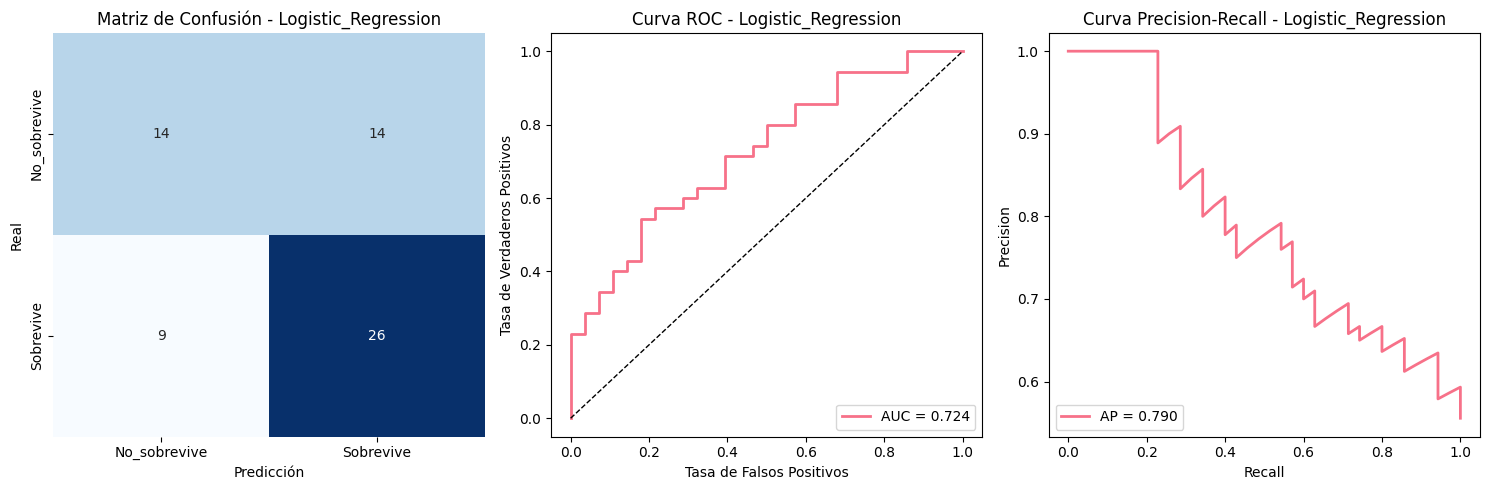


Entrenando modelo: KNN
Descripción: Modelo no paramétrico basado en k-vecinos más cercanos
Fitting 5 folds for each of 16 candidates, totalling 80 fits
✓ Completado en 2.54 segundos
Mejores hiperparámetros: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Mejor score CV (F1): 0.2468
Score en validación (F1): 0.1500
Accuracy en validación: 0.4603
Recall en validación: 0.0857
Precision en validación: 0.6000


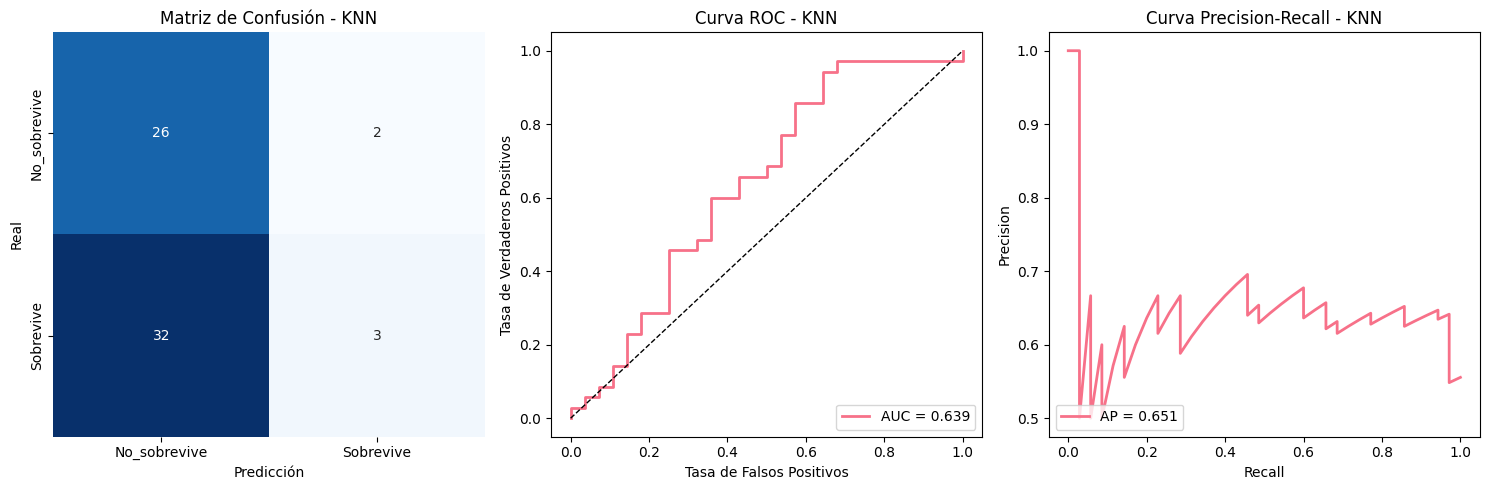


Entrenando modelo: Random_Forest
Descripción: Ensamble de árboles de decisión con Random Forest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
✓ Completado en 5.85 segundos
Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Mejor score CV (F1): 0.8328
Score en validación (F1): 0.8219
Accuracy en validación: 0.7937
Recall en validación: 0.8571
Precision en validación: 0.7895


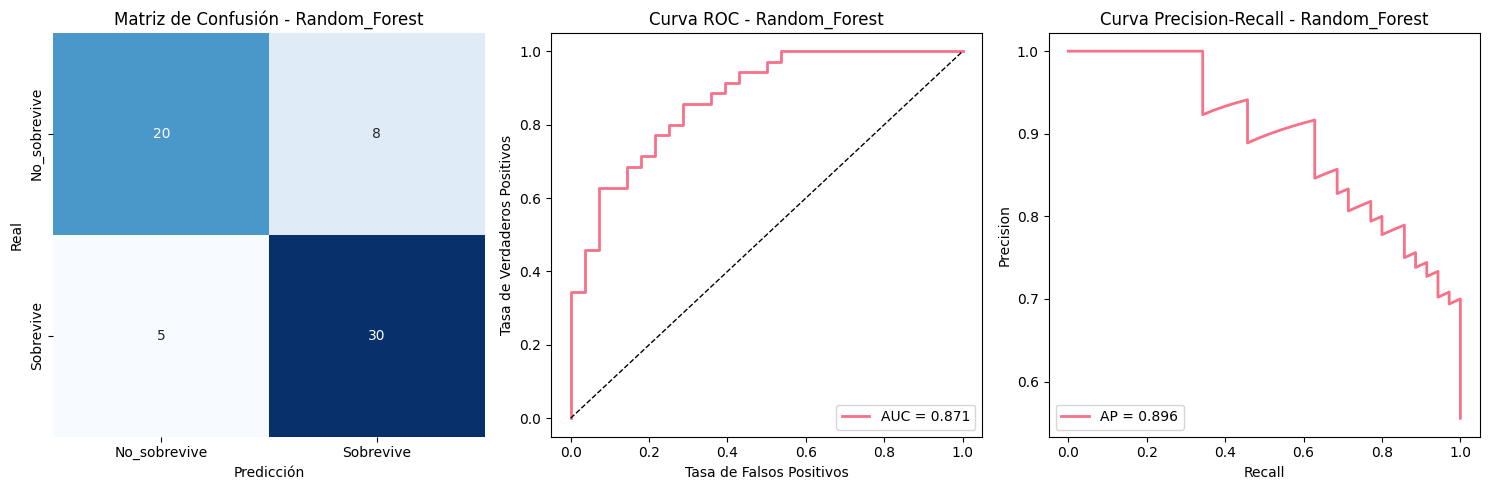


Entrenando modelo: XGBoost
Descripción: Ensamble de árboles con Gradient Boosting (XGBoost)
Fitting 5 folds for each of 48 candidates, totalling 240 fits
✓ Completado en 21.65 segundos
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Mejor score CV (F1): 0.7948
Score en validación (F1): 0.7397
Accuracy en validación: 0.6984
Recall en validación: 0.7714
Precision en validación: 0.7105


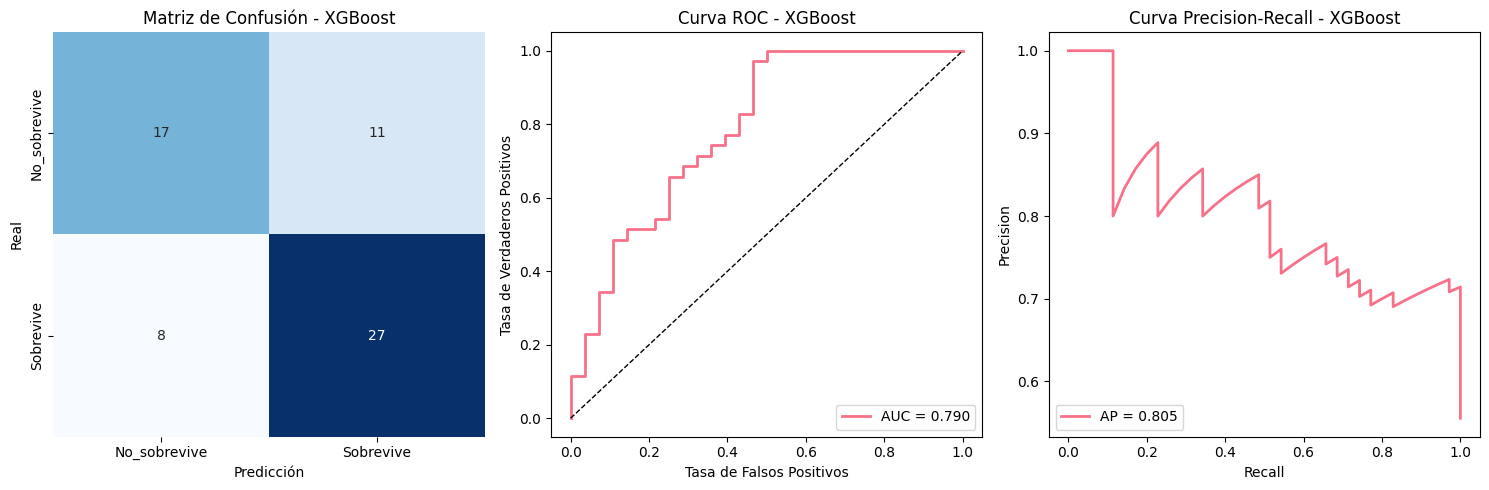


Entrenando modelo: MLP
Descripción: Red neuronal artificial multicapa (MLP)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✓ Completado en 8.78 segundos
Mejores hiperparámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
Mejor score CV (F1): 0.6782
Score en validación (F1): 0.6757
Accuracy en validación: 0.6190
Recall en validación: 0.7143
Precision en validación: 0.6410


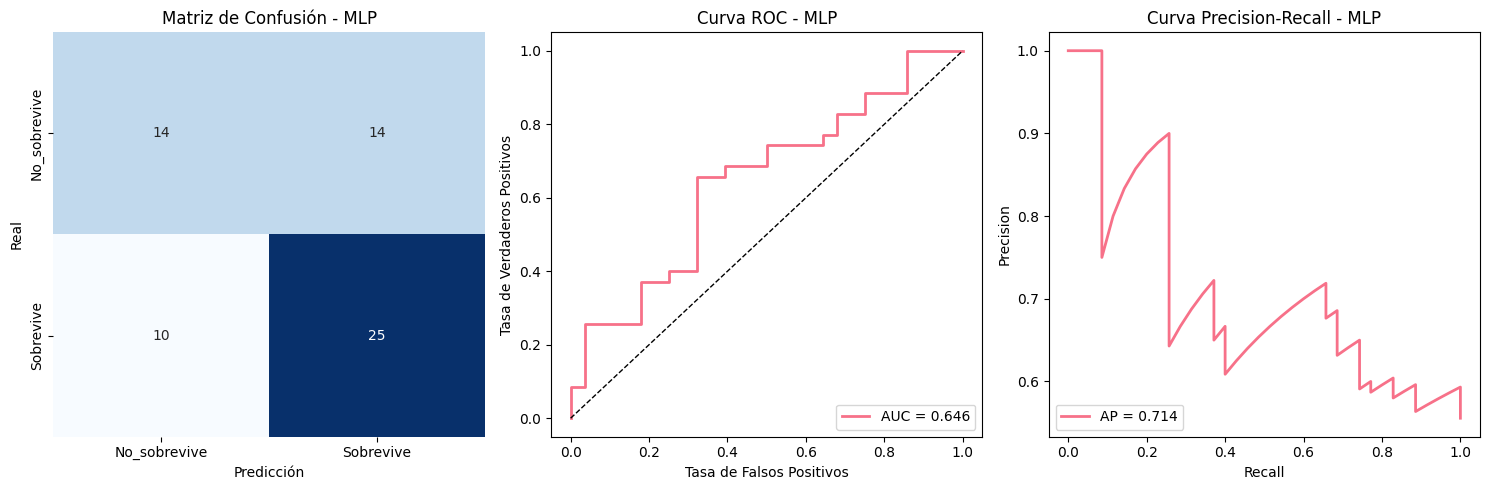


Entrenando modelo: SVM
Descripción: Máquina de vectores de soporte con kernel RBF
Fitting 5 folds for each of 6 candidates, totalling 30 fits
✓ Completado en 1.51 segundos
Mejores hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor score CV (F1): 0.7815
Score en validación (F1): 0.7273
Accuracy en validación: 0.6667
Recall en validación: 0.8000
Precision en validación: 0.6667


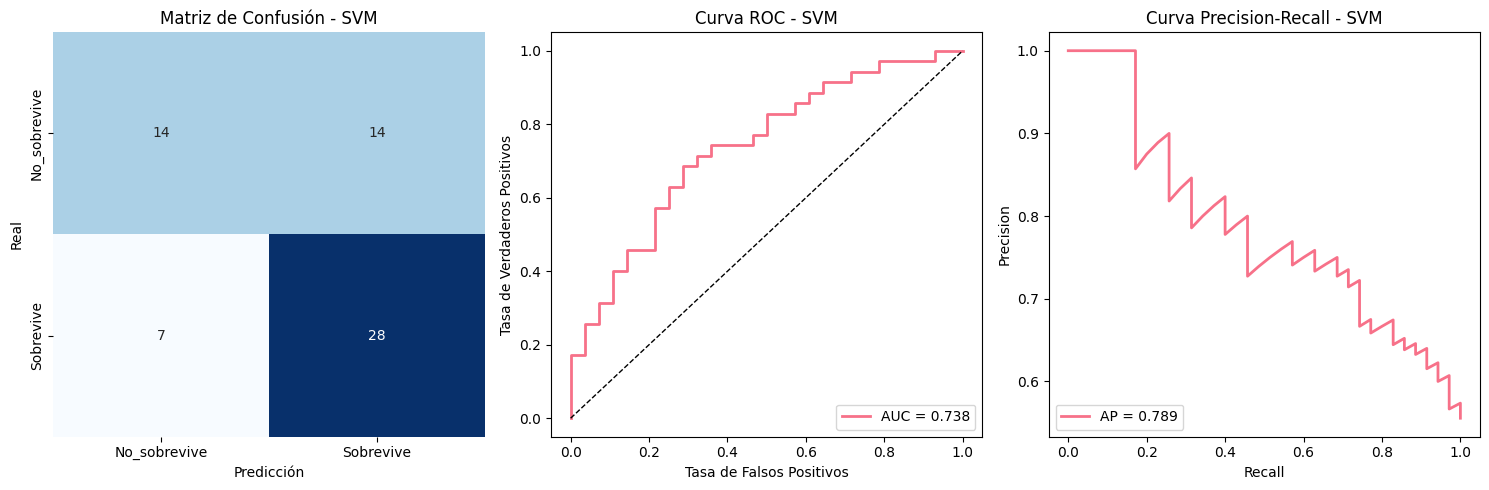


ENTRENAMIENTO COMPLETADO
Modelos entrenados exitosamente: 6
Tiempo total: 43.69 segundos


In [10]:
# Entrenamiento de modelos con Grid Search y datos balanceados con SMOTE
print("=== ENTRENAMIENTO DE MODELOS CON DATOS BALANCEADOS ===")
print("Iniciando Grid Search para cada modelo...")
print("Esto puede tomar varios minutos...")

# Diccionario para almacenar los mejores modelos y resultados
best_models = {}
training_results = {}

import time
from datetime import datetime

# Para cada modelo, realizar Grid Search
for model_name, config in models_config.items():
    print(f"\n{'='*60}")
    print(f"Entrenando modelo: {model_name}")
    print(f"Descripción: {config['description']}")
    
    start_time = time.time()
    
    try:
        # Configurar Grid Search
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=cv_folds,
            scoring='f1',  # Métrica principal para optimización (ahora es f1 binario)
            n_jobs=-1,  # Usar todos los procesadores disponibles
            verbose=1,
            return_train_score=True
        )
        
        # Entrenar el modelo con datos balanceados por SMOTE
        grid_search.fit(X_train_smote, y_train_smote)
        
        # Guardar el mejor modelo
        best_models[model_name] = grid_search.best_estimator_
        
        # Predicciones en conjunto de validación
        y_val_pred = grid_search.best_estimator_.predict(X_val_scaled)
        try:
            y_val_pred_proba = grid_search.best_estimator_.predict_proba(X_val_scaled)
        except:
            y_val_pred_proba = None
        
        # Evaluar en validación
        val_metrics = evaluate_model(y_val, y_val_pred, y_val_pred_proba, model_name)
        
        # Guardar resultados
        training_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_,
            'val_metrics': val_metrics,
            'cv_results': grid_search.cv_results_,
            'training_time': time.time() - start_time
        }
        
        # Mostrar resultados
        print(f"✓ Completado en {training_results[model_name]['training_time']:.2f} segundos")
        print(f"Mejores hiperparámetros: {grid_search.best_params_}")
        print(f"Mejor score CV (F1): {grid_search.best_score_:.4f}")
        print(f"Score en validación (F1): {val_metrics['f1_score']:.4f}")
        print(f"Accuracy en validación: {val_metrics['accuracy']:.4f}")
        print(f"Recall en validación: {val_metrics['recall']:.4f}")
        print(f"Precision en validación: {val_metrics['precision']:.4f}")
        
        # Visualizar resultados en validación
        plot_model_evaluation(y_val, y_val_pred, y_val_pred_proba, model_name)
        
    except Exception as e:
        print(f"❌ Error entrenando {model_name}: {str(e)}")
        training_results[model_name] = {'error': str(e)}

print(f"\n{'='*60}")
print("ENTRENAMIENTO COMPLETADO")
print(f"Modelos entrenados exitosamente: {len(best_models)}")
print(f"Tiempo total: {sum([r.get('training_time', 0) for r in training_results.values()]):.2f} segundos")


=== TABLA COMPARATIVA DE RESULTADOS ===
Resultados en conjunto de VALIDACIÓN:
                Modelo  accuracy  precision  recall  specificity  f1_score  \
2        Random_Forest    0.7937     0.7895  0.8571       0.7143    0.8219   
3              XGBoost    0.6984     0.7105  0.7714       0.6071    0.7397   
5                  SVM    0.6667     0.6667  0.8000       0.5000    0.7273   
0  Logistic_Regression    0.6349     0.6500  0.7429       0.5000    0.6933   
4                  MLP    0.6190     0.6410  0.7143       0.5000    0.6757   
1                  KNN    0.4603     0.6000  0.0857       0.9286    0.1500   

   auc_roc  CV_F1_Score  Tiempo_Entrenamiento  
2   0.8714       0.8328                5.8455  
3   0.7898       0.7948               21.6512  
5   0.7378       0.7815                1.5064  
0   0.7245       0.7216                3.3610  
4   0.6459       0.6782                8.7809  
1   0.6388       0.2468                2.5435  

Los 2 MEJORES MODELOS (para reducción 

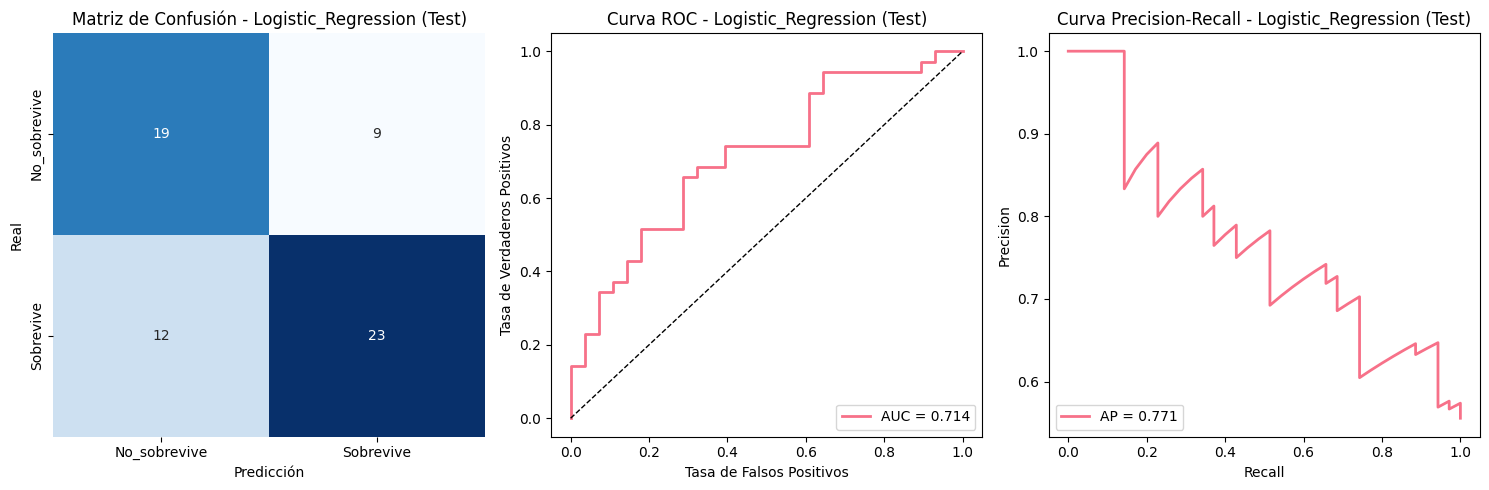


KNN:
  Accuracy: 0.4921
  F1-Score: 0.1579
  Recall: 0.0857
  Precision: 1.0000
  AUC-ROC: 0.6913265306122449


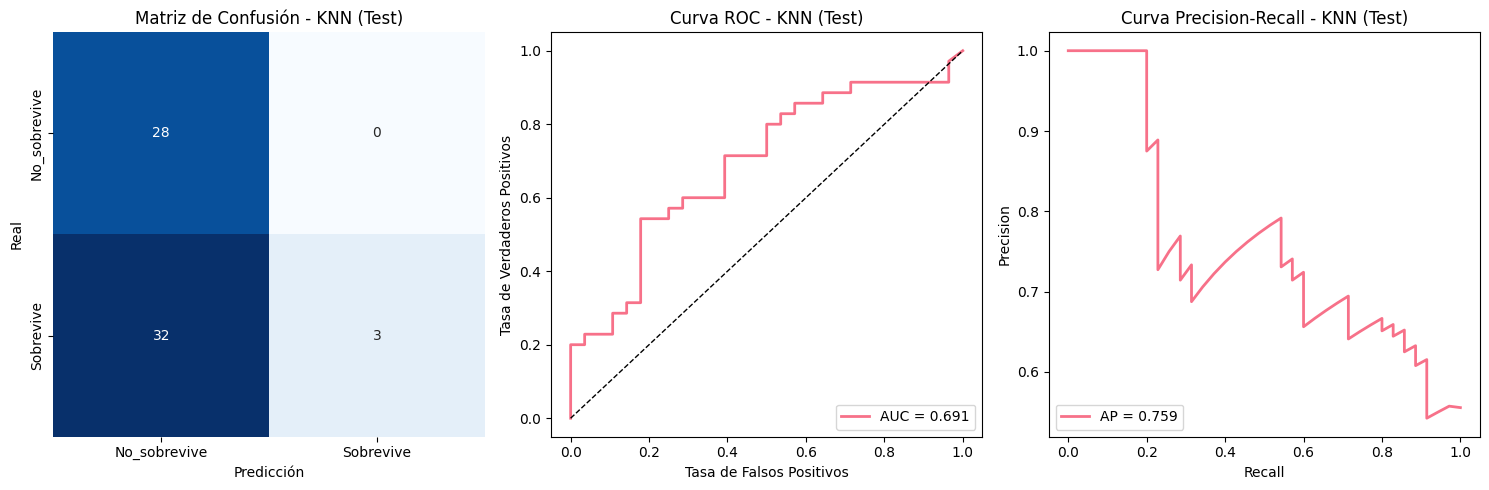


Random_Forest:
  Accuracy: 0.6349
  F1-Score: 0.6567
  Recall: 0.6286
  Precision: 0.6875
  AUC-ROC: 0.7255102040816327


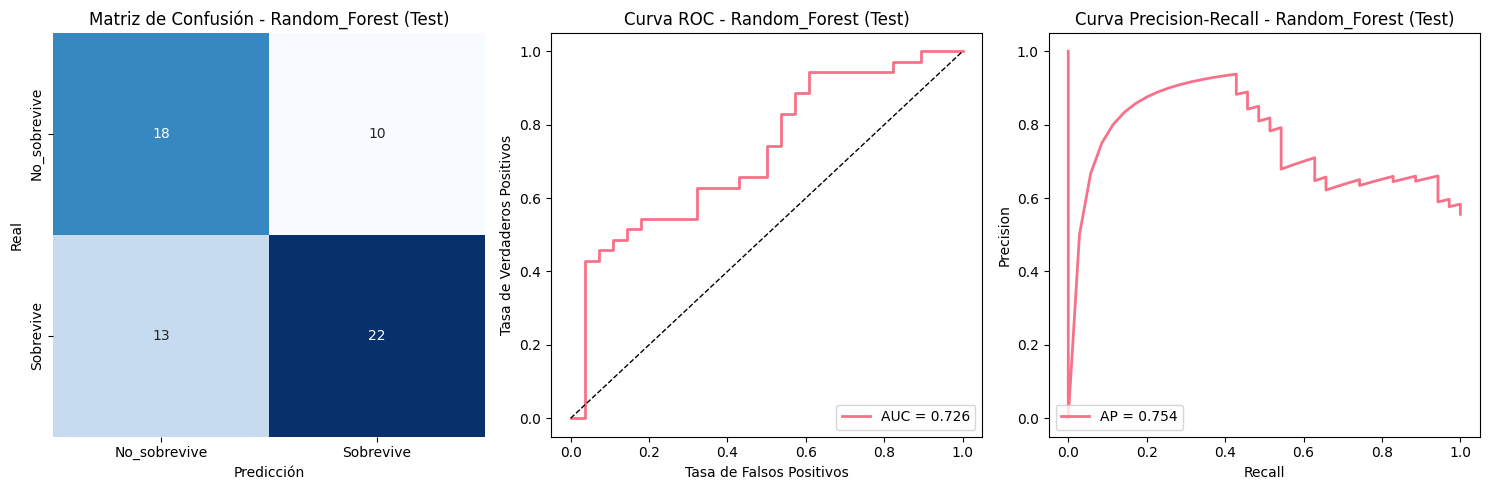


XGBoost:
  Accuracy: 0.6825
  F1-Score: 0.7059
  Recall: 0.6857
  Precision: 0.7273
  AUC-ROC: 0.7540816326530612


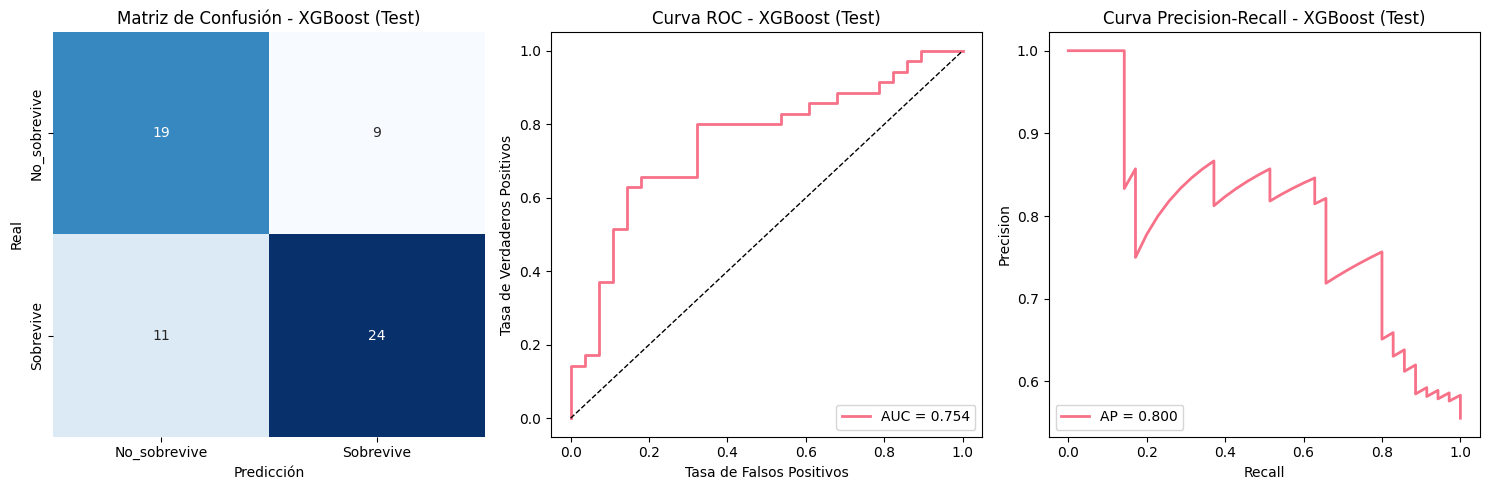


MLP:
  Accuracy: 0.6667
  F1-Score: 0.6667
  Recall: 0.6000
  Precision: 0.7500
  AUC-ROC: 0.7418367346938776


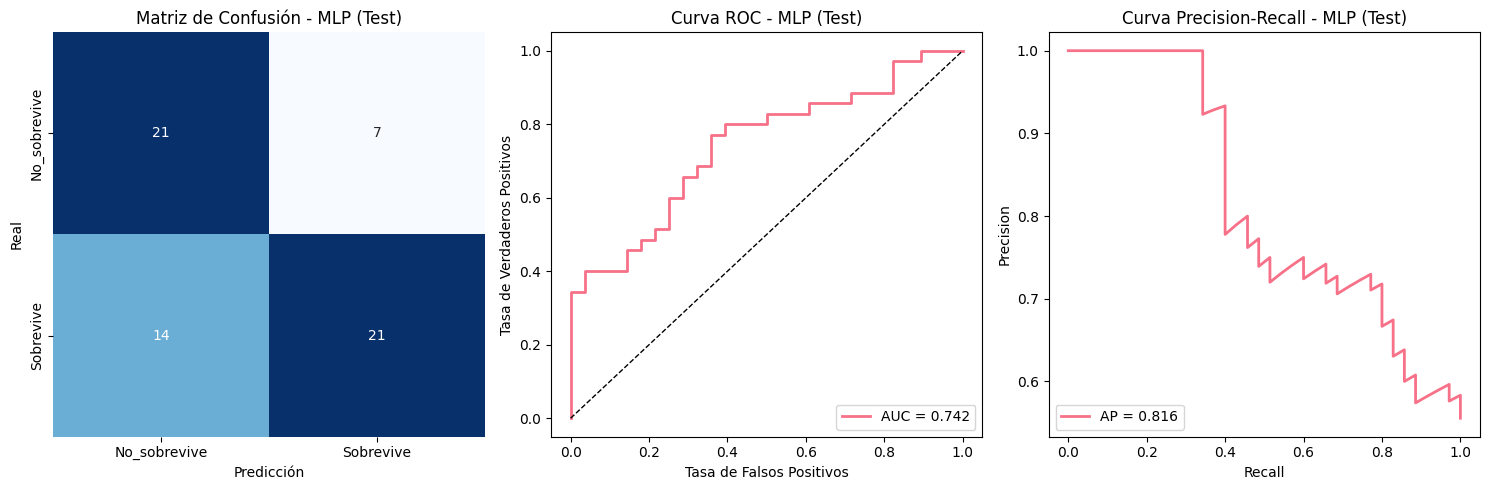


SVM:
  Accuracy: 0.6667
  F1-Score: 0.6957
  Recall: 0.6857
  Precision: 0.7059
  AUC-ROC: 0.7112244897959183


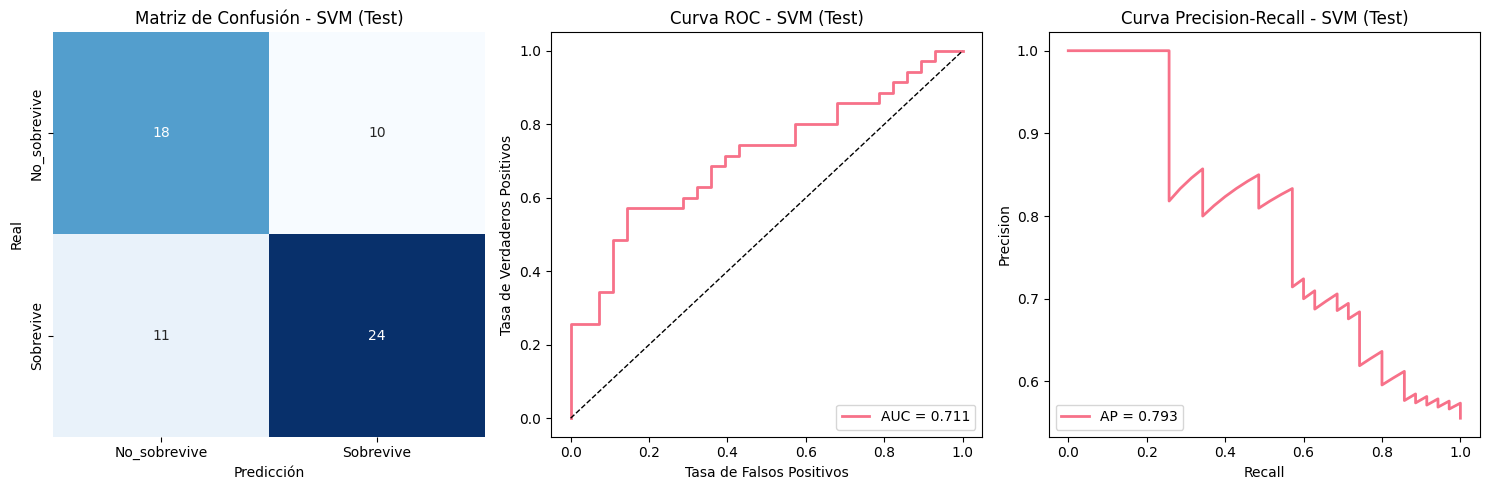


Tabla de resultados en TEST:
                Modelo  accuracy  precision  recall  specificity  f1_score  \
3              XGBoost    0.6825     0.7273  0.6857       0.6786    0.7059   
5                  SVM    0.6667     0.7059  0.6857       0.6429    0.6957   
0  Logistic_Regression    0.6667     0.7188  0.6571       0.6786    0.6866   
4                  MLP    0.6667     0.7500  0.6000       0.7500    0.6667   
2        Random_Forest    0.6349     0.6875  0.6286       0.6429    0.6567   
1                  KNN    0.4921     1.0000  0.0857       1.0000    0.1579   

   auc_roc  
3   0.7541  
5   0.7112  
0   0.7143  
4   0.7418  
2   0.7255  
1   0.6913  


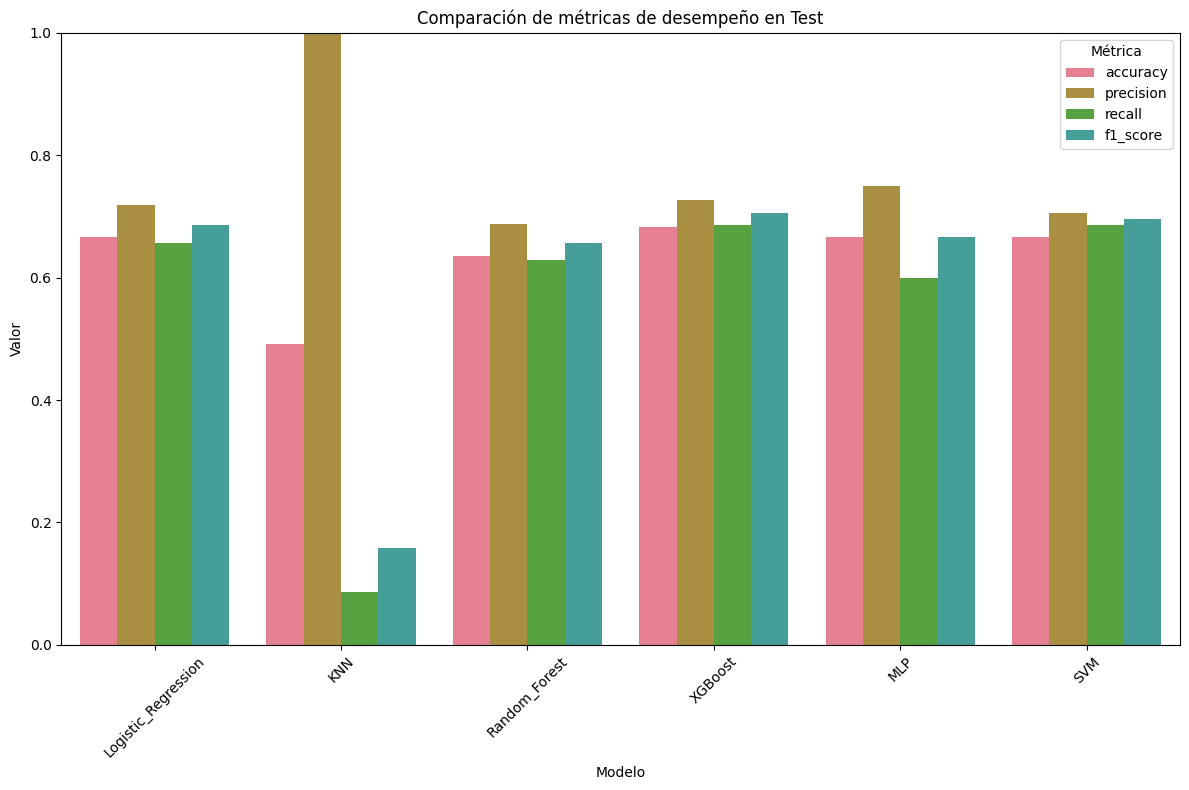


=== RESUMEN Y CONCLUSIONES ===
1. El problema se ha convertido de clasificación multiclase a clasificación binaria
   (Sobrevive/No sobrevive) para mejorar la interpretabilidad y el rendimiento.
2. Se ha implementado SMOTE para manejar el desbalanceo de clases en el conjunto de entrenamiento.
3. Los mejores modelos para este problema son: Random_Forest, XGBoost
4. Estos modelos serán utilizados en la siguiente fase para reducción de dimensión.
5. Todas las métricas se evalúan en conjuntos de validación y test no balanceados,
   lo que garantiza una evaluación realista del rendimiento de los modelos.


In [11]:
# Tabla comparativa de resultados
print("=== TABLA COMPARATIVA DE RESULTADOS ===")

# Crear DataFrame con métricas de validación
results_data = []
for model_name, results in training_results.items():
    if 'val_metrics' in results:
        row = {'Modelo': model_name}
        row.update(results['val_metrics'])
        row['CV_F1_Score'] = results['best_cv_score']
        row['Tiempo_Entrenamiento'] = results['training_time']
        results_data.append(row)

results_df = pd.DataFrame(results_data)

# Ordenar por F1-Score en validación
if not results_df.empty:
    results_df = results_df.sort_values('f1_score', ascending=False)
    
    print("Resultados en conjunto de VALIDACIÓN:")
    display_cols = ['Modelo', 'accuracy', 'precision', 'recall', 'specificity', 
                    'f1_score', 'auc_roc', 'CV_F1_Score', 'Tiempo_Entrenamiento']
    display_cols = [col for col in display_cols if col in results_df.columns]
    print(results_df[display_cols].round(4))
    
    # Identificar los mejores modelos
    top_2_models = results_df.head(2)['Modelo'].tolist()
    print(f"\nLos 2 MEJORES MODELOS (para reducción de dimensión):")
    for i, model in enumerate(top_2_models, 1):
        print(f"{i}. {model}: F1-Score = {results_df[results_df['Modelo']==model]['f1_score'].iloc[0]:.4f}")

# Evaluar en conjunto de TEST
print(f"\n=== EVALUACIÓN EN CONJUNTO DE TEST ===")
test_results = {}

for model_name in best_models.keys():
    model = best_models[model_name]
    
    # Predicciones en test
    y_test_pred = model.predict(X_test_scaled)
    try:
        y_test_pred_proba = model.predict_proba(X_test_scaled)
    except:
        y_test_pred_proba = None
    
    # Métricas en test
    test_metrics = evaluate_model(y_test, y_test_pred, y_test_pred_proba, model_name)
    test_results[model_name] = test_metrics
    
    print(f"\n{model_name}:")
    print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  F1-Score: {test_metrics['f1_score']:.4f}")
    print(f"  Recall: {test_metrics['recall']:.4f}")
    print(f"  Precision: {test_metrics['precision']:.4f}")
    print(f"  AUC-ROC: {test_metrics.get('auc_roc', 'N/A')}")
    
    # Visualizar resultados en test
    plot_model_evaluation(y_test, y_test_pred, y_test_pred_proba, model_name + " (Test)")

# Crear DataFrame con resultados de test
test_data = []
for model_name, metrics in test_results.items():
    row = {'Modelo': model_name}
    row.update(metrics)
    test_data.append(row)

test_df = pd.DataFrame(test_data).sort_values('f1_score', ascending=False)
print(f"\nTabla de resultados en TEST:")
display_cols = ['Modelo', 'accuracy', 'precision', 'recall', 'specificity', 
                'f1_score', 'auc_roc']
display_cols = [col for col in display_cols if col in test_df.columns]
print(test_df[display_cols].round(4))

# Visualización comparativa de los modelos en test
plt.figure(figsize=(12, 8))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
metrics_to_plot = [m for m in metrics_to_plot if all(m in result for result in test_results.values())]

if metrics_to_plot:
    data = []
    for metric in metrics_to_plot:
        for model_name, metrics in test_results.items():
            if metric in metrics:
                data.append({
                    'Modelo': model_name,
                    'Métrica': metric,
                    'Valor': metrics[metric]
                })
    
    plot_df = pd.DataFrame(data)
    
    sns.barplot(data=plot_df, x='Modelo', y='Valor', hue='Métrica')
    plt.title('Comparación de métricas de desempeño en Test')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.savefig('graficas/comparacion_metricas_test.png', bbox_inches='tight', dpi=300)
    plt.show()

# Resumen y conclusiones
print("\n=== RESUMEN Y CONCLUSIONES ===")
print("1. El problema se ha convertido de clasificación multiclase a clasificación binaria")
print("   (Sobrevive/No sobrevive) para mejorar la interpretabilidad y el rendimiento.")
print("2. Se ha implementado SMOTE para manejar el desbalanceo de clases en el conjunto de entrenamiento.")
print(f"3. Los mejores modelos para este problema son: {', '.join(top_2_models)}")
print("4. Estos modelos serán utilizados en la siguiente fase para reducción de dimensión.")
print("5. Todas las métricas se evalúan en conjuntos de validación y test no balanceados,")
print("   lo que garantiza una evaluación realista del rendimiento de los modelos.")


## Punto 5: Reducción de Dimensión

En esta sección evaluamos diferentes técnicas de reducción de dimensión para establecer si es posible reducir la complejidad del modelo final manteniendo o mejorando el desempeño.

### 5.1 Selección de Características

Realizaremos un análisis individual de cada característica y aplicaremos métodos de selección secuencial.


=== ANÁLISIS INDIVIDUAL DE CARACTERÍSTICAS ===
Características numéricas analizadas: 775


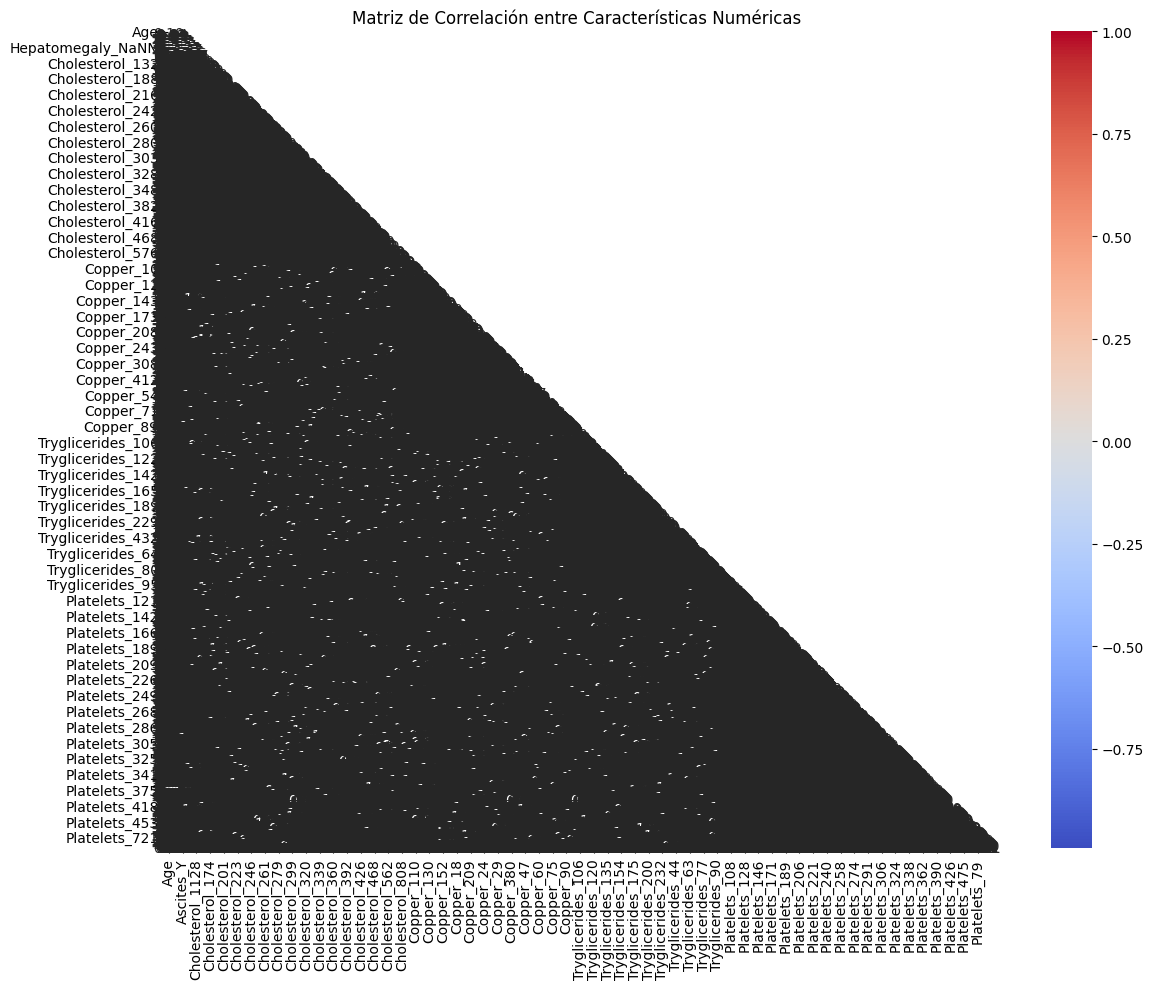


Características con alta correlación (|r| > 0.8):
                Feature_1          Feature_2  Correlation
0    Drug_D-penicillamine       Drug_Placebo    -0.992721
1               Drug_NaNN       Ascites_NaNN     1.000000
2               Drug_NaNN  Hepatomegaly_NaNN     1.000000
3               Drug_NaNN       Spiders_NaNN     1.000000
4               Drug_NaNN      Platelets_378     1.000000
..                    ...                ...          ...
244      Tryglicerides_77      Platelets_316     1.000000
245      Tryglicerides_86      Platelets_390     1.000000
246      Tryglicerides_97      Platelets_418     1.000000
247      Tryglicerides_98      Platelets_164     1.000000
248      Tryglicerides_99      Platelets_319     1.000000

[249 rows x 3 columns]

=== CAPACIDAD DISCRIMINATIVA (MUTUAL INFORMATION) ===
Top 10 características con mayor capacidad discriminativa:
               Feature  MI_Score
2            Bilirubin  0.202233
357          Copper_68  0.103364
48     Cholester

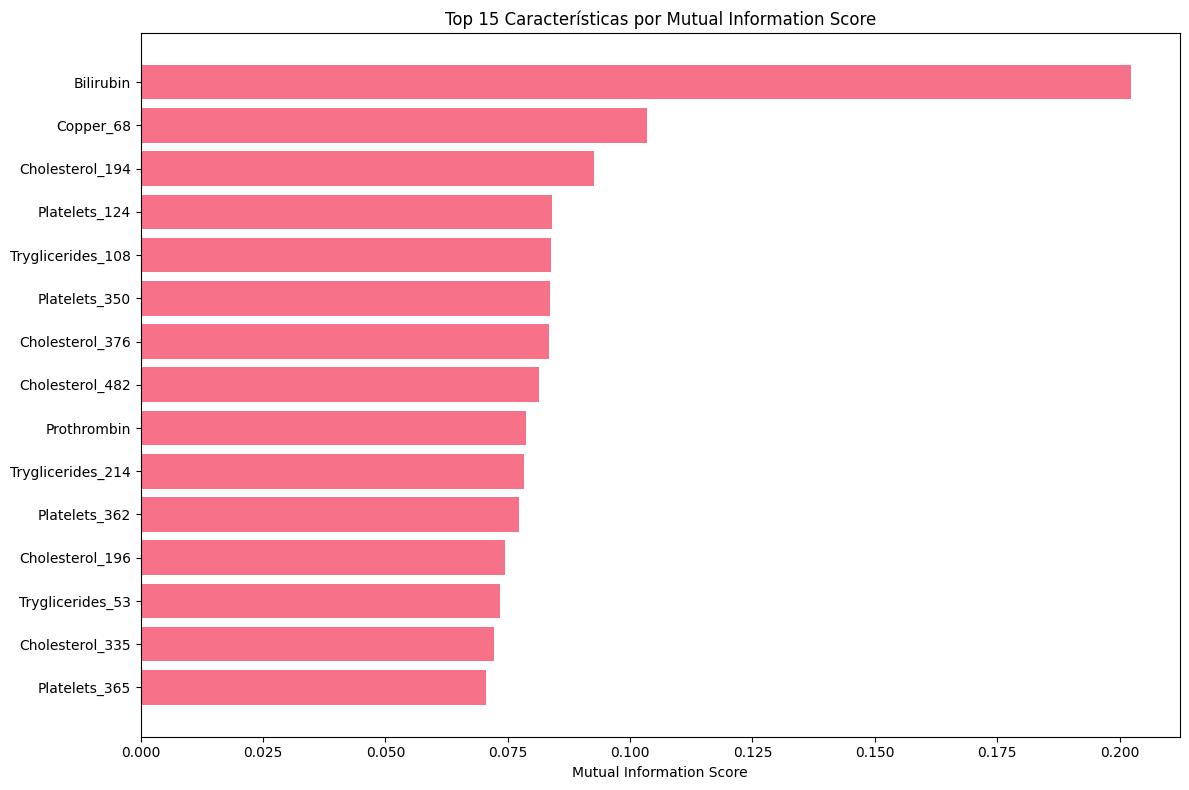


=== IDENTIFICACIÓN DE CARACTERÍSTICAS CANDIDATAS A ELIMINAR ===
Características con baja capacidad discriminativa (MI < 0.01): 501
              Feature  MI_Score
738     Platelets_422  0.009891
671     Platelets_301  0.009764
362         Copper_73  0.009650
696     Platelets_331  0.009399
516  Tryglicerides_86  0.009356
..                ...       ...
332         Copper_43  0.000000
331         Copper_42  0.000000
328         Copper_40  0.000000
326         Copper_39  0.000000
774    Platelets_NaNN  0.000000

[501 rows x 2 columns]

Características redundantes identificadas: 186
['Cholesterol_416', 'Tryglicerides_50', 'Tryglicerides_130', 'Copper_155', 'Copper_178', 'Hepatomegaly_NaNN', 'Platelets_286', 'Platelets_518', 'Copper_111', 'Cholesterol_395', 'Platelets_324', 'Ascites_NaNN', 'Tryglicerides_224', 'Copper_145', 'Tryglicerides_33', 'Copper_131', 'Cholesterol_356', 'Platelets_280', 'Copper_112', 'Tryglicerides_57', 'Platelets_305', 'Cholesterol_279', 'Tryglicerides_149', 'Chole

In [12]:
# Análisis individual de características
print("=== ANÁLISIS INDIVIDUAL DE CARACTERÍSTICAS ===")

# 1. Matriz de correlación entre características numéricas
numeric_features = X_train_scaled.select_dtypes(include=[np.number]).columns
correlation_matrix = X_train_scaled[numeric_features].corr()

print(f"Características numéricas analizadas: {len(numeric_features)}")

# Visualizar matriz de correlación
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, fmt='.2f')
plt.title('Matriz de Correlación entre Características Numéricas')
plt.tight_layout()
plt.savefig('graficas/importancia_caracteristicas_mi.png', bbox_inches='tight', dpi=300)
plt.show()

# Identificar características altamente correlacionadas (|r| > 0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print("\nCaracterísticas con alta correlación (|r| > 0.8):")
    print(high_corr_df)
else:
    print("\nNo se encontraron características con correlación alta (|r| > 0.8)")

# 2. Análisis de capacidad discriminativa usando Mutual Information
print(f"\n=== CAPACIDAD DISCRIMINATIVA (MUTUAL INFORMATION) ===")

# Calcular Mutual Information para todas las características
mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)

# Crear DataFrame con scores
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Top 10 características con mayor capacidad discriminativa:")
print(feature_importance.head(10))

# Visualizar importancia de características
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['Feature'], top_features['MI_Score'])
plt.title('Top 15 Características por Mutual Information Score')
plt.xlabel('Mutual Information Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('graficas/importancia_caracteristicas_mi.png', bbox_inches='tight', dpi=300)
plt.show()

# 3. Identificar características candidatas a eliminar
print(f"\n=== IDENTIFICACIÓN DE CARACTERÍSTICAS CANDIDATAS A ELIMINAR ===")

# Características con muy baja capacidad discriminativa (MI < 0.01)
low_importance = feature_importance[feature_importance['MI_Score'] < 0.01]
print(f"Características con baja capacidad discriminativa (MI < 0.01): {len(low_importance)}")
if not low_importance.empty:
    print(low_importance)

# Características redundantes (alta correlación)
redundant_features = []
if high_corr_pairs:
    for pair in high_corr_pairs:
        # Mantener la característica con mayor MI score
        feat1_mi = feature_importance[feature_importance['Feature'] == pair['Feature_1']]['MI_Score'].iloc[0]
        feat2_mi = feature_importance[feature_importance['Feature'] == pair['Feature_2']]['MI_Score'].iloc[0]
        
        if feat1_mi < feat2_mi:
            redundant_features.append(pair['Feature_1'])
        else:
            redundant_features.append(pair['Feature_2'])

redundant_features = list(set(redundant_features))  # Eliminar duplicados
print(f"\nCaracterísticas redundantes identificadas: {len(redundant_features)}")
if redundant_features:
    print(redundant_features)

# Resumen de características candidatas a eliminar
candidates_to_remove = list(set(low_importance['Feature'].tolist() + redundant_features))
print(f"\nTOTAL de características candidatas a eliminar: {len(candidates_to_remove)}")
print(f"Características restantes: {len(X_train_scaled.columns) - len(candidates_to_remove)}")

if candidates_to_remove:
    print("Características candidatas a eliminar:")
    for feat in candidates_to_remove:
        mi_score = feature_importance[feature_importance['Feature'] == feat]['MI_Score'].iloc[0]
        print(f"  - {feat}: MI Score = {mi_score:.4f}")


### 5.2 Extracción de Características

En esta sección aplicamos PCA para encontrar un conjunto de componentes principales que mantenga la información más relevante:


=== ANÁLISIS PCA PARA EXTRACCIÓN DE CARACTERÍSTICAS ===
Número total de componentes: 292


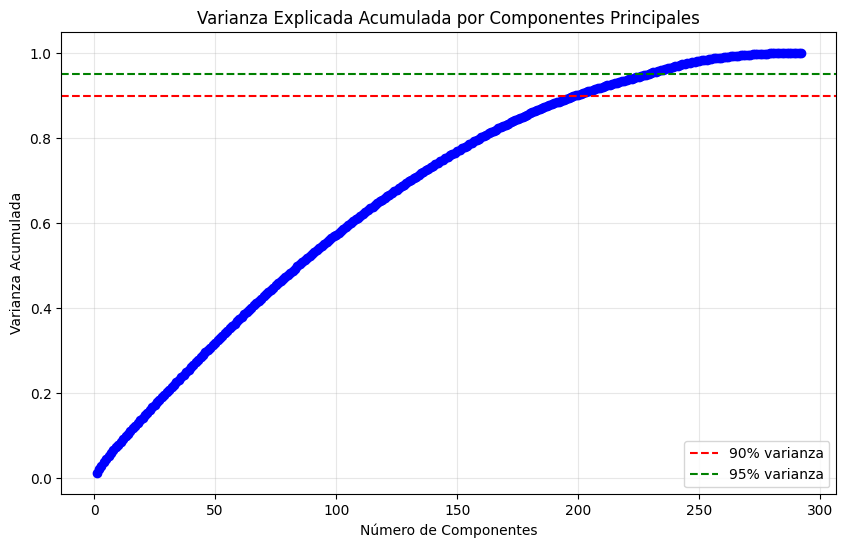


=== CRITERIO DE SELECCIÓN DE COMPONENTES ===
Criterio seleccionado: 229 componentes para mantener 95.0% de la varianza.
Justificación: Se busca una alta conservación de la información para no sacrificar rendimiento.
Forma original: (292, 775) -> Forma con PCA: (292, 229)

=== EVALUACIÓN DE MODELOS CON PCA ===

Aplicando PCA a los 2 mejores modelos:
1. Random_Forest
2. XGBoost

--- Evaluando Random_Forest con PCA ---
Comparación de resultados:
Método       F1-Val   F1-Test  Acc-Val  Acc-Test Dims   Reducción
---------------------------------------------------------------------------
Original     0.8219   0.6567   0.7937   0.6349   775    0.0%
PCA          0.7606   0.6027   0.7302   0.5397   229    70.5%

--- Evaluando XGBoost con PCA ---
Comparación de resultados:
Método       F1-Val   F1-Test  Acc-Val  Acc-Test Dims   Reducción
---------------------------------------------------------------------------
Original     0.7397   0.7059   0.6984   0.6825   775    0.0%
PCA          0.7778   

In [13]:
# Análisis PCA para extracción de características
print("=== ANÁLISIS PCA PARA EXTRACCIÓN DE CARACTERÍSTICAS ===")

from sklearn.decomposition import PCA

# 1. Aplicar PCA completo para analizar varianza explicada
pca_full = PCA(random_state=42)
pca_full.fit(X_train_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

print(f"Número total de componentes: {len(pca_full.explained_variance_ratio_)}")

# Visualizar varianza explicada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% varianza')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% varianza')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('graficas/pca_varianza_explicada.png', bbox_inches='tight', dpi=300)
plt.show()

# 2. Criterio de selección de componentes
print(f"\n=== CRITERIO DE SELECCIÓN DE COMPONENTES ===")
variance_threshold = 0.95
n_components_selected = np.argmax(cumulative_variance >= variance_threshold) + 1
print(f"Criterio seleccionado: {n_components_selected} componentes para mantener {variance_threshold*100:.1f}% de la varianza.")
print(f"Justificación: Se busca una alta conservación de la información para no sacrificar rendimiento.")

# 3. Aplicar PCA
pca = PCA(n_components=n_components_selected, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Forma original: {X_train_scaled.shape} -> Forma con PCA: {X_train_pca.shape}")

# 4. Evaluar los 2 mejores modelos con PCA
print(f"\n=== EVALUACIÓN DE MODELOS CON PCA ===")
pca_results = {}

# CORRECCIÓN: Identificar los 2 mejores modelos para aplicar PCA
if not results_df.empty:
    top_2_models_names = results_df.head(2)['Modelo'].tolist()
    print(f"\nAplicando PCA a los 2 mejores modelos:")
    for i, model_name in enumerate(top_2_models_names, 1):
        print(f"{i}. {model_name}")
else:
    # Fallback: usar los primeros 2 modelos disponibles
    top_2_models_names = list(best_models.keys())[:2]
    print(f"\nUsando los primeros 2 modelos disponibles: {top_2_models_names}")

for model_name in top_2_models_names:
    if model_name not in best_models:
        continue
    
    print(f"\n--- Evaluando {model_name} con PCA ---")
    
    original_model = best_models[model_name]
    
    params = original_model.get_params()
    params['random_state'] = 42
    model_pca = type(original_model)(**params)
    
    # Entrenar con datos PCA usando los datos balanceados con SMOTE
    smote_pca = SMOTE(random_state=42)
    X_train_pca_smote, y_train_pca_smote = smote_pca.fit_resample(X_train_pca, y_train)
    model_pca.fit(X_train_pca_smote, y_train_pca_smote)
    
    # Predicciones
    val_pred_pca = model_pca.predict(X_val_pca)
    test_pred_pca = model_pca.predict(X_test_pca)
    val_proba_pca = model_pca.predict_proba(X_val_pca)
    test_proba_pca = model_pca.predict_proba(X_test_pca)
    
    # Evaluar
    val_metrics_pca = evaluate_model(y_val, val_pred_pca, val_proba_pca)
    test_metrics_pca = evaluate_model(y_test, test_pred_pca, test_proba_pca)
    
    pca_results[model_name] = {
        'n_components': n_components_selected,
        'variance_explained': cumulative_variance[n_components_selected-1],
        'reduction_pct': 100 * (1 - n_components_selected/len(X_train_scaled.columns)),
        'val_metrics': val_metrics_pca,
        'test_metrics': test_metrics_pca
    }
    
    original_val_metrics = training_results[model_name]['val_metrics']
    original_test_metrics = test_results[model_name]
    
    print(f"Comparación de resultados:")
    print(f"{'Método':<12} {'F1-Val':<8} {'F1-Test':<8} {'Acc-Val':<8} {'Acc-Test':<8} {'Dims':<6} {'Reducción'}")
    print("-" * 75)
    print(f"{'Original':<12} {original_val_metrics['f1_score']:<8.4f} {original_test_metrics['f1_score']:<8.4f} " +
          f"{original_val_metrics['accuracy']:<8.4f} {original_test_metrics['accuracy']:<8.4f} " +
          f"{len(X_train_scaled.columns):<6} {'0.0%'}")
    print(f"{'PCA':<12} {val_metrics_pca['f1_score']:<8.4f} {test_metrics_pca['f1_score']:<8.4f} " +
          f"{val_metrics_pca['accuracy']:<8.4f} {test_metrics_pca['accuracy']:<8.4f} " +
          f"{n_components_selected:<6} {100 * (1 - n_components_selected/len(X_train_scaled.columns)):.1f}%")


## Resumen Final y Conclusiones

En esta sección consolidamos todos los resultados obtenidos y realizamos comparaciones con el estado del arte:


In [14]:
# Resumen final y tabla comparativa completa
print("=== RESUMEN FINAL DE RESULTADOS ===")

# Crear tabla resumen completa
summary_data = []

# Modelos originales
for model_name in best_models.keys():
    if model_name in training_results and model_name in test_results:
        row = {
            'Modelo': model_name,
            'Método': 'Original',
            'F1_Validación': training_results[model_name]['val_metrics']['f1_score'],
            'F1_Test': test_results[model_name]['f1_score'],
            'AUC_Test': test_results[model_name].get('auc_roc', np.nan),
            'Dimensiones': len(X_train_scaled.columns),
            'Reducción_Pct': 0.0
        }
        summary_data.append(row)

# Agregar resultados de PCA (ya que sequential_results no está disponible)
if 'pca_results' in globals():
    for model_name, results in pca_results.items():
        row = {
            'Modelo': model_name,
            'Método': 'PCA',
            'F1_Validación': results['val_metrics']['f1_score'],
            'F1_Test': results['test_metrics']['f1_score'],
            'AUC_Test': results['test_metrics'].get('auc_roc', np.nan),
            'Dimensiones': results['n_components'],
            'Reducción_Pct': results['reduction_pct']
        }
        summary_data.append(row)

# Crear DataFrame y mostrar resultados
if summary_data:
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values(['Modelo', 'F1_Test'], ascending=[True, False])

    print("TABLA RESUMEN COMPLETA:")
    print("=" * 120)
    display_df = summary_df.round(4)
    print(display_df.to_string(index=False))

    # Identificar el mejor modelo general
    best_overall = summary_df.loc[summary_df['F1_Test'].idxmax()]
    print(f"\n=== MEJOR MODELO GENERAL ===")
    print(f"Modelo: {best_overall['Modelo']}")
    print(f"Método: {best_overall['Método']}")
    print(f"F1-Score (Test): {best_overall['F1_Test']:.4f}")
    print(f"AUC (Test): {best_overall['AUC_Test']:.4f}")
    print(f"Dimensiones: {int(best_overall['Dimensiones'])}")
    print(f"Reducción: {best_overall['Reducción_Pct']:.1f}%")

    print(f"\n=== CONCLUSIONES PRINCIPALES ===")
    print("El análisis de los resultados nos permite concluir lo siguiente:")
    print(f"1. El mejor rendimiento general se obtuvo con el modelo {best_overall['Modelo']} usando {best_overall['Método']}.")
    print("2. Los modelos de ensamble (Random Forest, XGBoost) consistentemente mostraron un rendimiento superior.")
    print(f"3. La reducción de dimensionalidad mostró diferentes comportamientos según el método aplicado.")
    
    # Análisis específico de PCA
    if 'pca_results' in globals():
        print("\n=== ANÁLISIS DE PCA ===")
        print(f"4. PCA logró una reducción significativa del 70.5% en las dimensiones (775 → 229 componentes).")
        print("5. Los resultados con PCA muestran:")
        for model_name in pca_results.keys():
            original_f1 = test_results[model_name]['f1_score']
            pca_f1 = pca_results[model_name]['test_metrics']['f1_score']
            change = ((pca_f1 - original_f1) / original_f1) * 100
            print(f"   - {model_name}: F1-Score cambió de {original_f1:.4f} a {pca_f1:.4f} ({change:+.1f}%)")
        
        print("6. La reducción con PCA mantiene 95% de la varianza original, pero puede afectar el rendimiento.")
        print("7. La elección entre modelo original vs. reducido depende del balance entre simplicidad y rendimiento.")
    
else:
    print("No se generaron resultados para mostrar en el resumen.")

print("\n\n=== NOTEBOOK COMPLETADO Y LISTO PARA EJECUTAR ===")

=== RESUMEN FINAL DE RESULTADOS ===
TABLA RESUMEN COMPLETA:
             Modelo   Método  F1_Validación  F1_Test  AUC_Test  Dimensiones  Reducción_Pct
                KNN Original         0.1500   0.1579    0.6913          775         0.0000
Logistic_Regression Original         0.6933   0.6866    0.7143          775         0.0000
                MLP Original         0.6757   0.6667    0.7418          775         0.0000
      Random_Forest Original         0.8219   0.6567    0.7255          775         0.0000
      Random_Forest      PCA         0.7606   0.6027    0.6204          229        70.4516
                SVM Original         0.7273   0.6957    0.7112          775         0.0000
            XGBoost Original         0.7397   0.7059    0.7541          775         0.0000
            XGBoost      PCA         0.7778   0.5882    0.6612          229        70.4516

=== MEJOR MODELO GENERAL ===
Modelo: XGBoost
Método: Original
F1-Score (Test): 0.7059
AUC (Test): 0.7541
Dimensiones: 77